In [9]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import cm
from datetime import datetime
import glob
import os
import json
import pickle
import six
import charset_normalizer

sns.set()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

# load data

In [13]:
AllCSV = [i for i in glob.glob('*.{}'.format('csv'))]
AllCSV

['GBvideos.csv', 'USvideos.csv']

## id files

In [11]:
from google.cloud import storage
import pandas as pd

bucket_name = "heidless-jupyter-bucket-0"

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)

# When you have your files in a subfolder of the bucket.
my_prefix = "csv/" # the name of the subfolder
blobs = bucket.list_blobs(prefix = my_prefix, delimiter = '/')

AllCSV=[]

for blob in blobs:
    print(f'blob.name:{blob.name}')
    if(blob.name != my_prefix): # ignoring the subfolder itself 
        file_name = blob.name.replace(my_prefix, "")
        print(file_name)
        AllCSV.append(file_name)
        df = pd.read_csv(file_name) # load the data

blob.name:csv/
blob.name:csv/DEvideos.csv
DEvideos.csv


FileNotFoundError: [Errno 2] No such file or directory: 'DEvideos.csv'

## create dataframes

In [14]:
all_dataframes = [] # list to store each data frame separately

for csv in AllCSV:
    print(f'csv: {csv}')
    df = pd.read_csv(csv)
    df['country'] = csv[0:2] # adding column 'country' so that each dataset could be identified uniquely
    all_dataframes.append(df)

all_dataframes[0].head() # index 0 to 9 for [CA, DE, FR, GB, IN, JP, KR, MX, RU, US] datasets

csv: GBvideos.csv
csv: USvideos.csv


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,GB
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...,GB
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,GB
3,PUTEiSjKwJU,17.14.11,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,2017-11-13T02:30:38.000Z,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...,GB
4,rHwDegptbI4,17.14.11,Dashcam captures truck's near miss with child ...,Cute Girl Videos,25,2017-11-13T01:45:13.000Z,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...,GB


## clean columns
- convert to 'str'
    - video_id
    - trending_date
- create 'date' columns
- format year to '2010' format
- trending_date: replace with reformated date components
    - delete date work files
- identify and set 'categorical' data type
- 'publish_time' : set date format

In [15]:
for df in all_dataframes:
    # video_id 
    df['video_id'] = df['video_id'].astype('str') 

    # trending date
    df['trending_date'] = df['trending_date'].astype('str') 
    date_pieces = (df['trending_date']
                   .str.split('.')
                  )
    df['Year'] = date_pieces.str[0].astype(int)
    df['Day'] = date_pieces.str[1].astype(int)
    df['Month'] = date_pieces.str[2].astype(int)
    
    updatedyear = []
    for i in range(len(df)) : 
        y = df.loc[i, "Year"]
        newy = y+2000
        updatedyear.append(newy)
    for i in range(len(df)):
        newy = updatedyear[i]
        tr = df.loc[i, "Year"]
        df['Year'].replace(to_replace = tr, value = newy, inplace=True)
        
    del df['trending_date']
    df['trending_date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], format = "%Y-%m-%d")
    del df['Year']
    del df['Day']
    del df['Month']
    
    #title
    df['title'] = df['title'].astype('str')
    #channel_title
    df['channel_title'] = df['channel_title'].astype('str')
    #category_id
    df['category_id'] = df['category_id'].astype(str) 
    
    #tags
    df['tags'] = df['tags'].astype('str')
    
    #thumbnail_link
    df['thumbnail_link'] = df['thumbnail_link'].astype('str') 
    
    #description
    df['description'] = df['description'].astype('str')
    
    # Changing comments_disabled, ratings_disabled, video_error_or_removed from bool to categorical
    df['comments_disabled'] = df['comments_disabled'].astype('category') 
    df['ratings_disabled'] = df['ratings_disabled'].astype('category') 
    df['video_error_or_removed'] = df['video_error_or_removed'].astype('category')
    
    # publish_time 
    df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce', format='%Y-%m-%dT%H:%M:%S.%fZ')
    

- create 'publish_date' column 
    - strip only 'date' value from publish_time
    - set 'publish_time' to to only contain 'time' values 

In [16]:
for df in all_dataframes:
    df.insert(4, 'publish_date', df['publish_time'].dt.date) # loc, column name, values for column to be inserted
    df['publish_time'] = df['publish_time'].dt.time
# Changing data type for 'publish_date' from object to 'datetime64[ns]'
for df in all_dataframes:
     df['publish_date'] = pd.to_datetime(df['publish_date'], format = "%Y-%m-%d")

In [17]:
all_dataframes[0].head() # index 0 to 9 for [CA, DE, FR, GB, IN, JP, KR, MX, RU, US] datasets

,video_id,title,channel_title,category_id,publish_date,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,trending_date
0,Jw1Y-zhQURU,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10,07:38:29,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,GB,2017-11-14
1,3s1rvMFUweQ,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12,06:24:44,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...,GB,2017-11-14
2,n1WpP7iowLc,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10,17:00:03,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,GB,2017-11-14
3,PUTEiSjKwJU,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,2017-11-13,02:30:38,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...,GB,2017-11-14
4,rHwDegptbI4,Dashcam captures truck's near miss with child ...,Cute Girl Videos,25,2017-11-13,01:45:13,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...,GB,2017-11-14


In [18]:
# We can use any index from 0 to 9 inclusive (for each of the 10 dataframes
all_dataframes[1].dtypes

video_id                          object
title                             object
channel_title                     object
category_id                       object
publish_date              datetime64[ns]
publish_time                      object
tags                              object
views                              int64
likes                              int64
dislikes                           int64
comment_count                      int64
thumbnail_link                    object
comments_disabled               category
ratings_disabled                category
video_error_or_removed          category
description                       object
country                           object
trending_date             datetime64[ns]
dtype: object

### choose index

In [19]:
for df in all_dataframes:
    df.set_index('video_id', inplace=True)

## handle missing values
- using 'heatmap'
    - absences will show as 'orangle' square

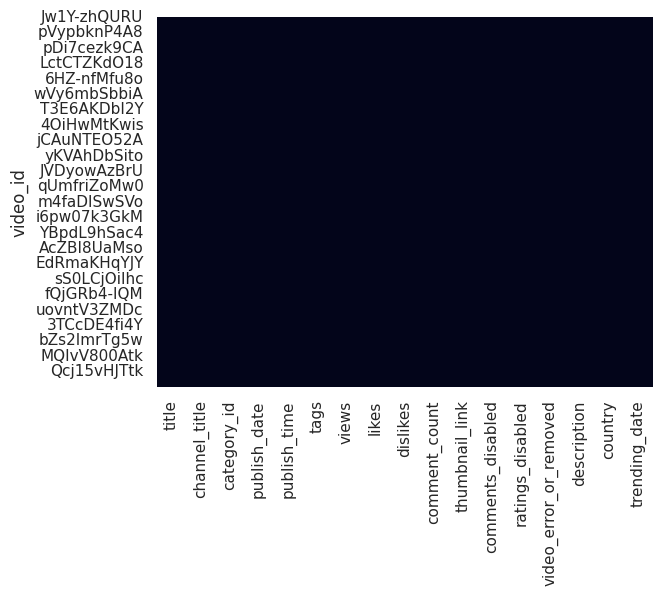

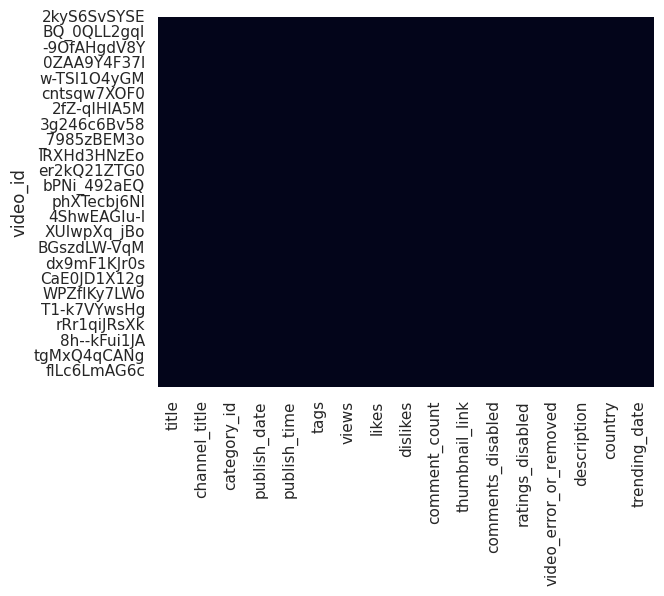

<Figure size 640x480 with 0 Axes>

In [20]:
for df in all_dataframes:
    sns.heatmap(df.isnull(), cbar=False)
    plt.figure()

# EDA prep

## consolidate dataframes

In [21]:
combined_df = pd.concat(all_dataframes)


In [22]:
# Making copy of original dataframe
backup_df = combined_df.reset_index().sort_values('trending_date', ascending=False).set_index('video_id')

### sort as appropriate
in this case latest 'trending_date' will be at top

In [23]:
# Sorting according to latest trending date while removing duplicates
combined_df = combined_df.reset_index().sort_values('trending_date', ascending=False).drop_duplicates('video_id',keep='first').set_index('video_id')

In [24]:
# Doing the same above operation for each of the individual dataframes in the list we created earlier
for df in all_dataframes:
    df = df.reset_index().sort_values('trending_date', ascending=False).set_index('video_id')

In [25]:
# Printing results
combined_df[['publish_date','publish_time','trending_date', 'country']].head()

,publish_date,publish_time,trending_date,country
video_id,,,,
ooyjaVdt-jA,2018-05-17,17:09:38,2018-06-14,US
AbEHRrq7xwU,2018-05-18,17:35:05,2018-06-14,GB
-bx_vG94LSo,2018-05-23,12:00:00,2018-06-14,GB
FjqBekVMwjQ,2018-05-23,16:30:01,2018-06-14,GB
7zLzYiw1wdQ,2018-05-12,09:41:52,2018-06-14,GB


### Inserting Category Column
One of our final steps for the data cleaning of the data sets was checking the JSON files that
were available with the data sets. We needed to see whether or not these files contained any useful data. 
As there were multiple files, we decided to read two files at random, in order to check whether they contained the same
data or were they all containing different data.

json file pulled from file sytem

expore pulling frpm 'cloud storage'

In [27]:
# read file
with open('GB_category_id.json', 'r') as f:  # reading one randomly selected json files to make sense of its contents
    data = f.read()
# parse file
obj = json.loads(data)
# printing
obj

{'kind': 'youtube#videoCategoryListResponse',
 'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/1v2mrzYSYG6onNLt2qTj13hkQZk"',
 'items': [{'kind': 'youtube#videoCategory',
   'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/Xy1mB4_yLrHy_BmKmPBggty2mZQ"',
   'id': '1',
   'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ',
    'title': 'Film & Animation',
    'assignable': True}},
  {'kind': 'youtube#videoCategory',
   'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/UZ1oLIIz2dxIhO45ZTFR3a3NyTA"',
   'id': '2',
   'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ',
    'title': 'Autos & Vehicles',
    'assignable': True}},
  {'kind': 'youtube#videoCategory',
   'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/nqRIq97-xe5XRZTxbknKFVe5Lmg"',
   'id': '10',
   'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ',
    'title': 'Music',
    'assignable': True}},
  {'kind': 'youtube#videoCategory',
   'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/HwXKamM1Q20q9BN-oBJavSGkfDI"',
   'id': '15',
   'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdnt

#### insert 'category' column & set based on json definition

In [29]:
category_id = {}
with open('GB_category_id.json', 'r') as f:
    d = json.load(f)
    for category in d['items']:
        category_id[category['id']] = category['snippet']['title']
combined_df.insert(2, 'category', combined_df['category_id'].map(category_id))
backup_df.insert(2, 'category', backup_df['category_id'].map(category_id))
for df in all_dataframes:
    df.insert(2, 'category', df['category_id'].map(category_id))
# Printing cleaned combined dataframe
combined_df.head(3)

,title,channel_title,category,category_id,publish_date,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,trending_date
video_id,,,,,,,,,,,,,,,,,,
ooyjaVdt-jA,Official Call of Duty®: Black Ops 4 — Multipla...,Call of Duty,Gaming,20,2018-05-17,17:09:38,"call of duty|""cod""|""activision""|""Black Ops 4""",10306119,357079,212976,144795,https://i.ytimg.com/vi/ooyjaVdt-jA/default.jpg,False,False,False,Call of Duty: Black Ops 4 Multiplayer raises t...,US,2018-06-14
AbEHRrq7xwU,Drake & Lil Baby - Yes Indeed (Lyrics),FutureHype,Music,10,2018-05-18,17:35:05,"music|""hiphop""|""hip""|""hop""|""rap""|""mix""|""remix""...",6230350,60003,2337,2030,https://i.ytimg.com/vi/AbEHRrq7xwU/default.jpg,False,False,False,• Download Drake & Lil Baby - Yes Indeed (Lyri...,GB,2018-06-14
-bx_vG94LSo,Bazzi - Beautiful (Official Video),Bazzi,Music,10,2018-05-23,12:00:00,"Bazzi|""Bautiful""|""Mine""|""Cosmic""|""Official Aud...",3177766,92573,1301,4276,https://i.ytimg.com/vi/-bx_vG94LSo/default.jpg,False,False,False,Beautiful by Bazzi - Official Music VideoStrea...,GB,2018-06-14


In [30]:
combined_df['category'].unique()

array(['Gaming', 'Music', 'Entertainment', 'Comedy', 'Film & Animation',
       'People & Blogs', 'Pets & Animals', 'Sports', 'Shows',
       'Howto & Style', 'News & Politics', 'Education',
       'Science & Technology', 'Travel & Events', nan, 'Autos & Vehicles'],
      dtype=object)

# EDA

<Axes: xlabel='ratio', ylabel='category'>

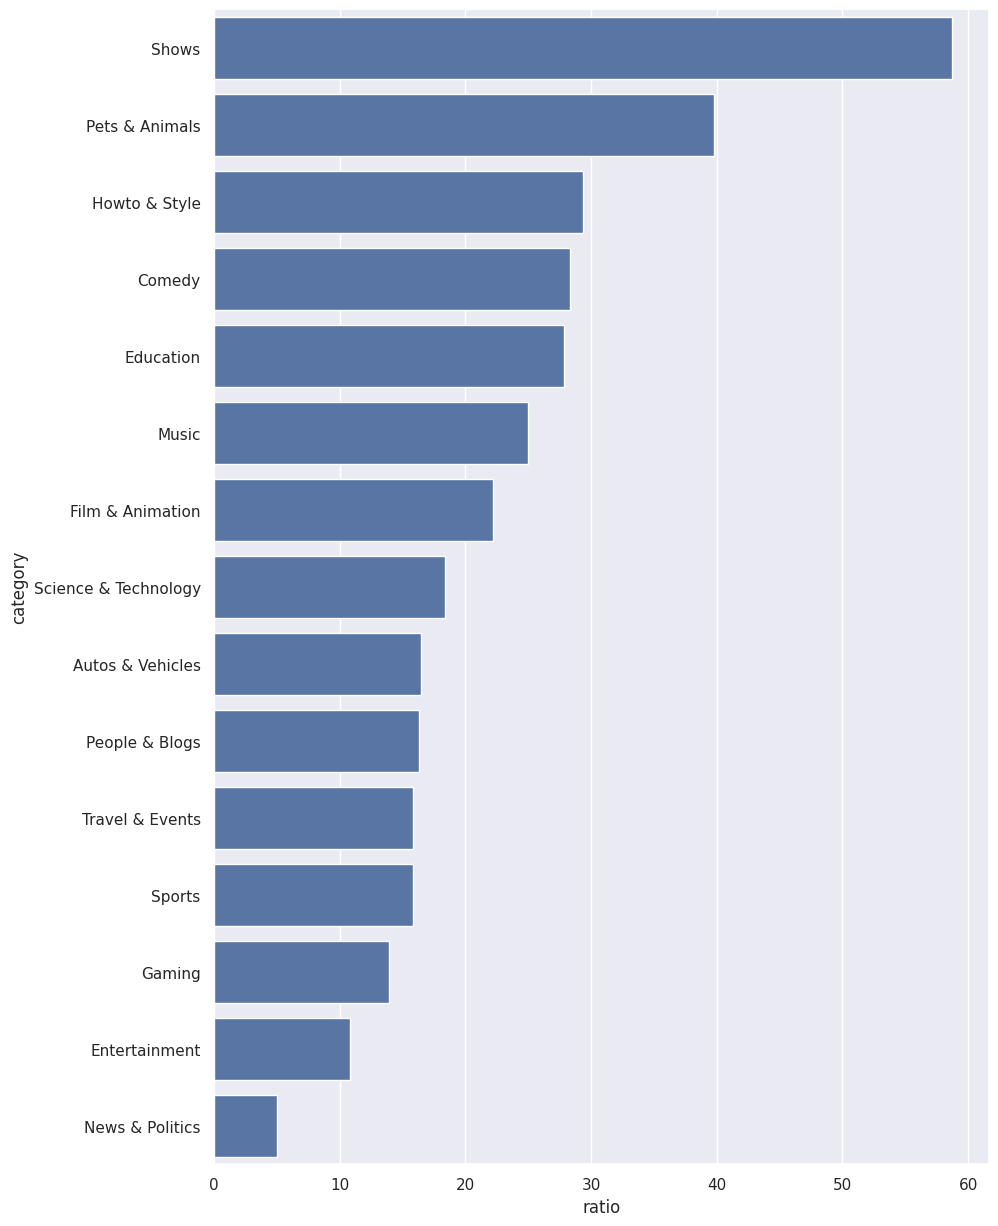

In [31]:
# calculating total likes for each category
likesdf = combined_df.groupby('category')['likes'].agg('sum')

# calculating total dislikes for each category
dislikesdf = combined_df.groupby('category')['dislikes'].agg('sum')

# calculating ratios of likes to dislikes
ratiodf = likesdf/dislikesdf 

# most liked category to appear on top
ratiodf = ratiodf.sort_values(ascending=False).reset_index()

# plotting bar chart
ratiodf.columns = ['category','ratio']
plt.subplots(figsize=(10, 15))
sns.barplot(x="ratio", y="category", data=ratiodf,
            label="Likes-Dislikes Ratio", color="b")

#### Observations:

We see that videos belonging to the pets and animals categories have the highest ratio of likes to dislikes 
videos among the trending categories whereas new and politics videos have the least. 
From this we can infer that people are less divided on the content of videos based on entertainment than compared to 
topics such as News, whose content can lead to a division of opinions among the user.

#### Users like videos from which category more?
Next, we moved on to observe which categories were more preferred by the users, based on the likes on the videos in each category.
Three of the outputs were randomly selected from the ten plotted graphs and results are as follows:

    df.set_index('video_id', inplace=True)
    
    all_dataframes[0].head() # index 0 to 9 for [CA, DE, FR, GB, IN, JP, KR, MX, RU, US] datasets


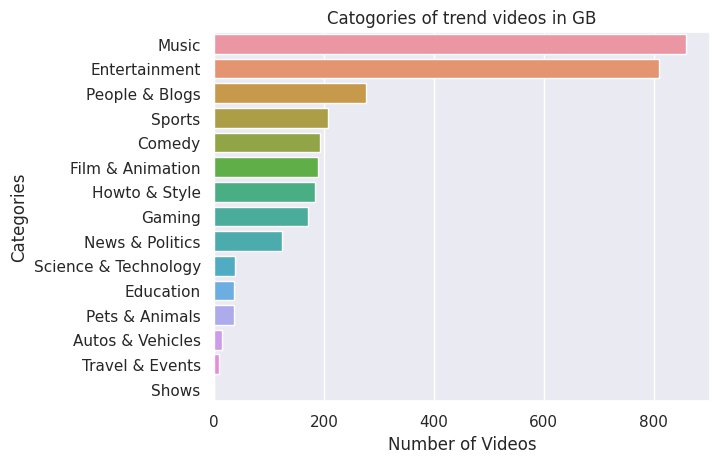

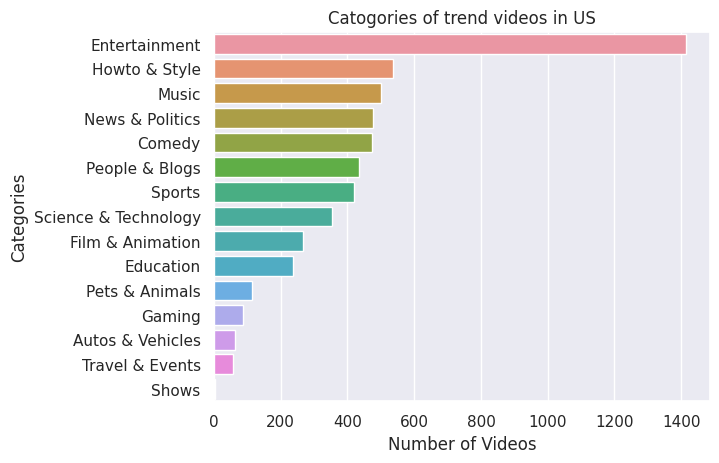

In [34]:
# Getting names of all countries
countries = []
allcsv = [i for i in glob.glob('*.{}'.format('csv'))]
for csv in allcsv:
    c = csv[0:2]
    countries.append(c)
for country in countries:
    if country == 'US':
        tempdf = combined_df[combined_df['country']==country]['category'].value_counts().reset_index()
        ax = sns.barplot(y=tempdf['category'], x=tempdf['count'], data=tempdf, orient='h')
        plt.xlabel("Number of Videos")
        plt.ylabel("Categories")
        plt.title("Catogories of trend videos in " + country)
    else:
        tempdf = combined_df[combined_df['country']==country]['category'].value_counts().reset_index()
        ax = sns.barplot(y=tempdf['category'], x=tempdf['count'], data=tempdf, orient='h')
        plt.xlabel("Number of Videos")
        plt.ylabel("Categories")
        plt.title("Catogories of trend videos in " + country)
        plt.figure()